In [1]:
import pickle
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F

import sys
sys.path.append("..")
from RandomErasing import RandomErasing

import torchvision.models
from torchvision import transforms

from albumentations import Compose, ShiftScaleRotate, GridDistortion
from albumentations.pytorch import ToTensor

In [2]:
def prepare_data(df, unknown_to_known):
    df = df.reset_index()
    df['slno'] = df.assign(slno=1).groupby('audio_filename')['slno'].cumsum()
    df.set_index(['audio_filename', 'slno'], inplace=True)

    df_unknown = df.copy().loc[:, list(unknown_to_known.keys())]
    df.drop(columns=list(unknown_to_known.keys()), inplace=True)

    y_mask = df.copy()
    y_mask.loc[:, :] = 1
    for unknown, known in unknown_to_known.items():
        y_mask.loc[
            df_unknown[unknown] > 0.5,
            known
        ] = 0

    df = df.swaplevel(i=1, j=0, axis=0).sort_index()

    y_mask = y_mask.swaplevel(i=1, j=0, axis=0).sort_index()

    y = np.concatenate([
        df.loc[[1], :].values[..., np.newaxis],
        df.loc[[2], :].values[..., np.newaxis],
        df.loc[[3], :].values[..., np.newaxis]
    ], axis=2)

    y_mask = np.concatenate([
        y_mask.loc[[1], :].values[..., np.newaxis],
        y_mask.loc[[2], :].values[..., np.newaxis],
        y_mask.loc[[3], :].values[..., np.newaxis]
    ], axis=2)

    X = np.concatenate([
        np.expand_dims(np.load('../../data/logmelspec/{}.npy'.format(x)).T[:635, :], axis=0)
        for x in df.loc[[1], :].reset_index(1).audio_filename.tolist()])
    X = np.expand_dims(X, axis=1)

    return X, y, y_mask


random_erasing = RandomErasing()


class AudioDataset(Dataset):

    def __init__(self, X, y, weights, transform=None):
        self.X = X
        self.y = y
        self.weights = weights
        self.transform = transform
        self.pil = transforms.ToPILImage()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        sample = self.X[idx, ...]

        if self.transform:
            # min-max transformation
            this_min = sample.min()
            this_max = sample.max()
            sample = (sample - this_min) / (this_max - this_min)

            # randomly cycle the file
            i = np.random.randint(sample.shape[1])
            sample = torch.cat([
                sample[:, i:, :],
                sample[:, :i, :]],
                dim=1)

            # apply albumentations transforms
            sample = np.array(self.pil(sample))
            sample = self.transform(image=sample)
            sample = sample['image']
            sample = sample[None, :, :].permute(0, 2, 1)

            # apply random erasing
            sample = random_erasing(sample.clone().detach())

            # revert min-max transformation
            sample = (sample * (this_max - this_min)) + this_min

        return sample, self.y[idx, ...], self.weights[idx, ...]

In [3]:
# Load and prepare data
with open('../../data/metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)

unknown_to_known = (
    pd.merge(metadata['taxonomy_df'].loc[lambda x: x.fine_id == 'X', ['fine', 'coarse']],
             metadata['taxonomy_df'].loc[lambda x: x.fine_id != 'X', ['fine', 'coarse']],
             on='coarse', how='inner')
    .drop(columns='coarse')
    .groupby('fine_x')['fine_y']
    .apply(lambda x: list(x)).to_dict())
known_labels = metadata['taxonomy_df'].loc[lambda x: x.fine_id != 'X'].fine.tolist()

train_df = pd.concat([metadata['coarse_train'], metadata['fine_train']], axis=1, sort=True)
valid_df = pd.concat([metadata['coarse_test'], metadata['fine_test']], axis=1, sort=True)

In [4]:
# manual correction for one data point
train_df.loc[(train_df.sum(axis=1) == 37).copy(), :] = 0
valid_df.loc[(valid_df.sum(axis=1) == 37).copy(), :] = 0

In [5]:
train_X, train_y, train_y_mask = prepare_data(train_df, unknown_to_known)
valid_X, valid_y, valid_y_mask = prepare_data(valid_df, unknown_to_known)

In [6]:
# Channel wise normalization
channel_means = train_X.reshape(-1, 128).mean(axis=0).reshape(1, 1, 1, -1)
channel_stds = train_X.reshape(-1, 128).std(axis=0).reshape(1, 1, 1, -1)
train_X = (train_X - channel_means) / channel_stds
valid_X = (valid_X - channel_means) / channel_stds

In [7]:
# Define the data augmentation transformations
albumentations_transform = Compose([
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0.5),
    GridDistortion(),
    ToTensor()
])

In [8]:
# Create the datasets and the dataloaders
train_dataset = AudioDataset(torch.Tensor(train_X),
                             torch.Tensor(train_y),
                             torch.Tensor(train_y_mask),
                             albumentations_transform)
valid_dataset = AudioDataset(torch.Tensor(valid_X),
                             torch.Tensor(valid_y),
                             torch.Tensor(valid_y_mask),
                             None)

val_loader = DataLoader(valid_dataset, 16, shuffle=False)
train_loader_1 = DataLoader(train_dataset, 16, shuffle=True)
train_loader_2 = DataLoader(train_dataset, 16, shuffle=True)

---

In [9]:
(np.min(train_X),
 np.mean(train_X),
 np.median(train_X),
 np.max(train_X),
 np.quantile(train_X, 0.25),
 np.quantile(train_X, 0.75))

(-4.320325501025387,
 -1.6221432905186037e-13,
 -0.20615205257469454,
 5.856143103520437,
 -0.7684339386533267,
 0.6658041000484232)

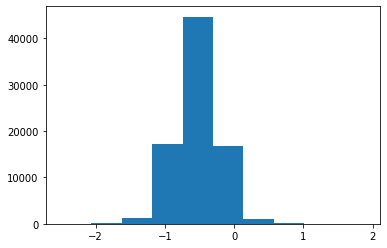

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(train_X[0].reshape(-1));

In [11]:
(np.min(valid_X),
 np.mean(valid_X),
 np.median(valid_X),
 np.max(valid_X),
 np.quantile(valid_X, 0.25),
 np.quantile(valid_X, 0.75))

(-3.220554099317004,
 -0.04937556515118184,
 -0.2779255644429254,
 6.532760464119584,
 -0.6986408119781202,
 0.40127430650001294)

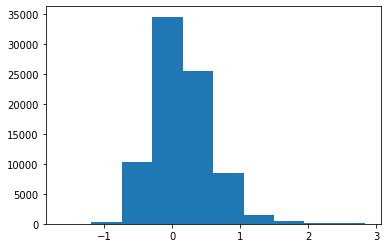

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(valid_X[0].reshape(-1));

---

In [13]:
# Define the device to be used
cuda = True
device = torch.device('cuda:0' if cuda else 'cpu')
print('Device: ', device)

Device:  cuda:0


In [14]:
def load_weights(weight_file):
    if weight_file == None:
        return

    try:
        weights_dict = np.load(weight_file).item()
    except:
        weights_dict = np.load(weight_file, encoding='bytes').item()

    return weights_dict

In [15]:
class KitModel(nn.Module):

    
    def __init__(self, weight_file):
        super(KitModel, self).__init__()
        self.__weights_dict = load_weights(weight_file)

        self.batch_normalization_1 = self.__batch_normalization(2, 'batch_normalization_1', num_features=1, eps=0.001, momentum=0.99)
        self.conv2d_1 = self.__conv(2, name='conv2d_1', in_channels=1, out_channels=64, kernel_size=(3, 3), stride=(1, 1), groups=1, bias=True)
        self.batch_normalization_2 = self.__batch_normalization(2, 'batch_normalization_2', num_features=64, eps=0.001, momentum=0.99)
        self.conv2d_2 = self.__conv(2, name='conv2d_2', in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), groups=1, bias=True)
        self.batch_normalization_3 = self.__batch_normalization(2, 'batch_normalization_3', num_features=64, eps=0.001, momentum=0.99)
        self.conv2d_3 = self.__conv(2, name='conv2d_3', in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), groups=1, bias=True)
        self.batch_normalization_4 = self.__batch_normalization(2, 'batch_normalization_4', num_features=128, eps=0.001, momentum=0.99)
        self.conv2d_4 = self.__conv(2, name='conv2d_4', in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), groups=1, bias=True)
        self.batch_normalization_5 = self.__batch_normalization(2, 'batch_normalization_5', num_features=128, eps=0.001, momentum=0.99)
        self.conv2d_5 = self.__conv(2, name='conv2d_5', in_channels=128, out_channels=256, kernel_size=(3, 3), stride=(1, 1), groups=1, bias=True)
        self.batch_normalization_6 = self.__batch_normalization(2, 'batch_normalization_6', num_features=256, eps=0.001, momentum=0.99)
        self.conv2d_6 = self.__conv(2, name='conv2d_6', in_channels=256, out_channels=256, kernel_size=(3, 3), stride=(1, 1), groups=1, bias=True)
        self.batch_normalization_7 = self.__batch_normalization(2, 'batch_normalization_7', num_features=256, eps=0.001, momentum=0.99)
        self.conv2d_7 = self.__conv(2, name='conv2d_7', in_channels=256, out_channels=512, kernel_size=(3, 3), stride=(1, 1), groups=1, bias=True)
        self.batch_normalization_8 = self.__batch_normalization(2, 'batch_normalization_8', num_features=512, eps=0.001, momentum=0.99)
        self.audio_embedding_layer = self.__conv(2, name='audio_embedding_layer', in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), groups=1, bias=True)

    def forward(self, x):
        conv2d_1_pad    = F.pad(x, (1, 1, 1, 1))
        conv2d_1        = self.conv2d_1(conv2d_1_pad)
        batch_normalization_2 = self.batch_normalization_2(conv2d_1)
        activation_1    = F.relu(batch_normalization_2)
        conv2d_2_pad    = F.pad(activation_1, (1, 1, 1, 1))
        conv2d_2        = self.conv2d_2(conv2d_2_pad)
        batch_normalization_3 = self.batch_normalization_3(conv2d_2)
        activation_2    = F.relu(batch_normalization_3)
        max_pooling2d_1 = F.max_pool2d(activation_2, kernel_size=(2, 2), stride=(2, 2), padding=0, ceil_mode=False)
        conv2d_3_pad    = F.pad(max_pooling2d_1, (1, 1, 1, 1))
        conv2d_3        = self.conv2d_3(conv2d_3_pad)
        batch_normalization_4 = self.batch_normalization_4(conv2d_3)
        activation_3    = F.relu(batch_normalization_4)
        conv2d_4_pad    = F.pad(activation_3, (1, 1, 1, 1))
        conv2d_4        = self.conv2d_4(conv2d_4_pad)
        batch_normalization_5 = self.batch_normalization_5(conv2d_4)
        activation_4    = F.relu(batch_normalization_5)
        max_pooling2d_2 = F.max_pool2d(activation_4, kernel_size=(2, 2), stride=(2, 2), padding=0, ceil_mode=False)
        conv2d_5_pad    = F.pad(max_pooling2d_2, (1, 1, 1, 1))
        conv2d_5        = self.conv2d_5(conv2d_5_pad)
        batch_normalization_6 = self.batch_normalization_6(conv2d_5)
        activation_5    = F.relu(batch_normalization_6)
        conv2d_6_pad    = F.pad(activation_5, (1, 1, 1, 1))
        conv2d_6        = self.conv2d_6(conv2d_6_pad)
        batch_normalization_7 = self.batch_normalization_7(conv2d_6)
        activation_6    = F.relu(batch_normalization_7)
        max_pooling2d_3 = F.max_pool2d(activation_6, kernel_size=(2, 2), stride=(2, 2), padding=0, ceil_mode=False)
        conv2d_7_pad    = F.pad(max_pooling2d_3, (1, 1, 1, 1))
        conv2d_7        = self.conv2d_7(conv2d_7_pad)
        batch_normalization_8 = self.batch_normalization_8(conv2d_7)
        activation_7    = F.relu(batch_normalization_8)
        audio_embedding_layer_pad = F.pad(activation_7, (1, 1, 1, 1))
        audio_embedding_layer = self.audio_embedding_layer(audio_embedding_layer_pad)
        max_pooling2d_4 = F.max_pool2d(audio_embedding_layer, kernel_size=(4, 8), stride=(4, 8), padding=0, ceil_mode=False)
        return max_pooling2d_4


    def __batch_normalization(self, dim, name, **kwargs):
        if   dim == 0 or dim == 1:  layer = nn.BatchNorm1d(**kwargs)
        elif dim == 2:  layer = nn.BatchNorm2d(**kwargs)
        elif dim == 3:  layer = nn.BatchNorm3d(**kwargs)
        else:           raise NotImplementedError()

        if 'scale' in self.__weights_dict[name]:
            layer.state_dict()['weight'].copy_(torch.from_numpy(self.__weights_dict[name]['scale']))
        else:
            layer.weight.data.fill_(1)

        if 'bias' in self.__weights_dict[name]:
            layer.state_dict()['bias'].copy_(torch.from_numpy(self.__weights_dict[name]['bias']))
        else:
            layer.bias.data.fill_(0)

        layer.state_dict()['running_mean'].copy_(torch.from_numpy(self.__weights_dict[name]['mean']))
        layer.state_dict()['running_var'].copy_(torch.from_numpy(self.__weights_dict[name]['var']))
        return layer

    def __conv(self, dim, name, **kwargs):
        if   dim == 1:  layer = nn.Conv1d(**kwargs)
        elif dim == 2:  layer = nn.Conv2d(**kwargs)
        elif dim == 3:  layer = nn.Conv3d(**kwargs)
        else:           raise NotImplementedError()

        layer.state_dict()['weight'].copy_(torch.from_numpy(self.__weights_dict[name]['weights']))
        if 'bias' in self.__weights_dict[name]:
            layer.state_dict()['bias'].copy_(torch.from_numpy(self.__weights_dict[name]['bias']))
        return layer

In [16]:
class Task5Model(nn.Module):

    def __init__(self, num_classes):

        super().__init__()
        
        self.bn = nn.BatchNorm2d(1)

        self.openl3 = KitModel('./openl3_no_mel_layer_pytorch_weights')

        self.final = nn.Sequential(
            nn.BatchNorm1d(512),
            nn.Linear(512, num_classes))

    def forward(self, x):
        x = x.permute(0, 1, 3, 2) # keras model had (92, 128, 199, 1) like shape
        x = self.bn(x)
        x = self.openl3(x)
        x = x.max(dim=-1)[0].max(dim=-1)[0]
        x = self.final(x)
        return x

In [17]:
# Instantiate the model
model = Task5Model(31).to(device)

In [18]:
model

Task5Model(
  (bn): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (openl3): KitModel(
    (batch_normalization_1): BatchNorm2d(1, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
    (conv2d_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (batch_normalization_2): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
    (conv2d_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (batch_normalization_3): BatchNorm2d(64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
    (conv2d_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (batch_normalization_4): BatchNorm2d(128, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
    (conv2d_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (batch_normalization_5): BatchNorm2d(128, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
    (conv2d_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1

In [19]:
# Define optimizer, scheduler and loss criteria
optimizer = optim.Adam(model.parameters(), lr=0.001, amsgrad=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)
criterion = nn.BCEWithLogitsLoss(reduction='none')

In [ ]:
epochs = 100
train_loss_hist = []
valid_loss_hist = []
lowest_val_loss = np.inf
epochs_without_new_lowest = 0

for i in range(epochs):
    print('Epoch: ', i)

    this_epoch_train_loss = 0
    for i1, i2 in zip(train_loader_1, train_loader_2):

        # mixup the inputs ---------
        alpha = 1
        mixup_vals = np.random.beta(alpha, alpha, i1[0].shape[0])

        lam = torch.Tensor(mixup_vals.reshape(mixup_vals.shape[0], 1, 1, 1))
        inputs = (lam * i1[0]) + ((1 - lam) * i2[0])

        lam = torch.Tensor(mixup_vals.reshape(mixup_vals.shape[0], 1, 1))
        labels = (lam * i1[1]) + ((1 - lam) * i2[1])
        masks = (lam * i1[2]) + ((1 - lam) * i2[2])
        # mixup ends ----------

        inputs = inputs.to(device)
        labels = labels.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            model = model.train()
            outputs = model(inputs)
            # calculate loss for each set of annotations
            loss_0 = criterion(outputs, labels[:, :, 0]) * masks[:, :, 0]
            loss_1 = criterion(outputs, labels[:, :, 1]) * masks[:, :, 1]
            loss_2 = criterion(outputs, labels[:, :, 2]) * masks[:, :, 2]
            loss = (loss_0.sum() + loss_1.sum() + loss_2.sum()) / masks.sum()
            loss.backward()
            optimizer.step()
            this_epoch_train_loss += loss.detach().cpu().numpy()

    this_epoch_valid_loss = 0
    for inputs, labels, masks in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(False):
            model = model.eval()
            outputs = model(inputs)
            loss_0 = criterion(outputs, labels[:, :, 0]) * masks[:, :, 0]
            loss_1 = criterion(outputs, labels[:, :, 1]) * masks[:, :, 1]
            loss_2 = criterion(outputs, labels[:, :, 2]) * masks[:, :, 2]
            loss = (loss_0.sum() + loss_1.sum() + loss_2.sum()) / masks.sum()
            this_epoch_valid_loss += loss.detach().cpu().numpy()

    this_epoch_train_loss /= len(train_loader_1)
    this_epoch_valid_loss /= len(val_loader)

    train_loss_hist.append(this_epoch_train_loss)
    valid_loss_hist.append(this_epoch_valid_loss)

    if this_epoch_valid_loss < lowest_val_loss:
        lowest_val_loss = this_epoch_valid_loss
        torch.save(model.state_dict(), './model_system1')
        epochs_without_new_lowest = 0
    else:
        epochs_without_new_lowest += 1

    if epochs_without_new_lowest >= 25:
        break

    print(this_epoch_train_loss, this_epoch_valid_loss)

    scheduler.step(this_epoch_valid_loss)

Epoch:  0
0.4053396038254913 0.1620012702686446
Epoch:  1
0.17613646266411762 0.15798584584678924
Epoch:  2
0.1733832455613986 0.17738483580095427
Epoch:  3
0.17020063173203243 0.15283765643835068
Epoch:  4
0.16867618658104722 0.176861756082092
Epoch:  5
0.16630145167412402 0.15322211597646987
Epoch:  6
0.16524767845260854 0.1593046643372093
Epoch:  7
0.1646308768160489 0.14973355137876102
Epoch:  8
0.16359720627466837 0.14084659383765288
Epoch:  9
0.16243001119214662 0.16445187026900904
Epoch:  10
0.16126727267187468 0.13925366795488767
Epoch:  11
0.161516390183345 0.13796378139938628
Epoch:  12
0.16044095330903319 0.13887232887957776
Epoch:  13
0.15957330187567237 0.13806300849786826
Epoch:  14
0.1590770064365296 0.13792910453464305
Epoch:  15
0.15837847360340104 0.13701242288308485
Epoch:  16
0.1584162662933473 0.1352191317294325
Epoch:  17
0.1579636491480328 0.13493077669824874
Epoch:  18
0.15815928117150352 0.14395052487296717
Epoch:  19
0.15781083358388368 0.14023449192089693
Epo